Checking NLTK resources...
Found punkt
Found stopwords


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...



Preprocessing text...

Naive Bayes Results:
Accuracy: 0.9704

Confusion Matrix:
[[965   0]
 [ 33 117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.78      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



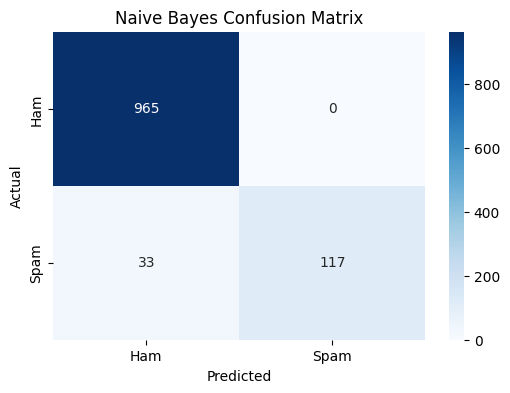


Logistic Regression Results:
Accuracy: 0.9516

Confusion Matrix:
[[961   4]
 [ 50 100]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.67      0.79       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115



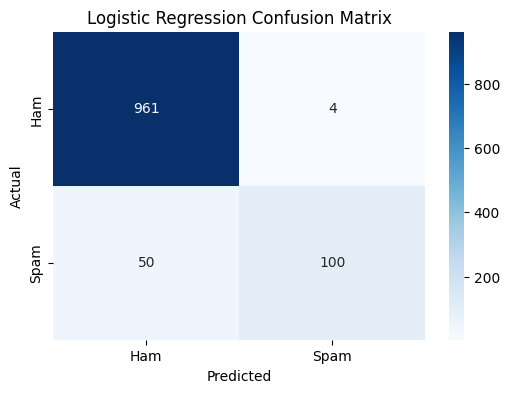


Support Vector Machine Results:
Accuracy: 0.9803

Confusion Matrix:
[[963   2]
 [ 20 130]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



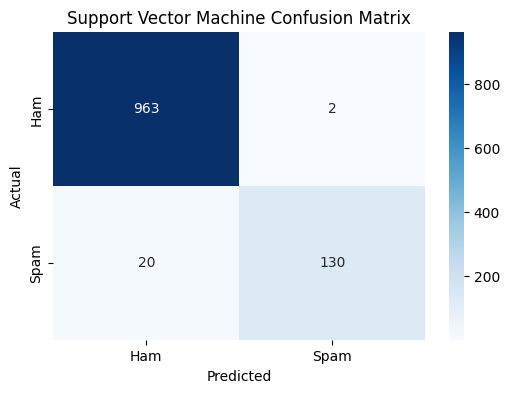

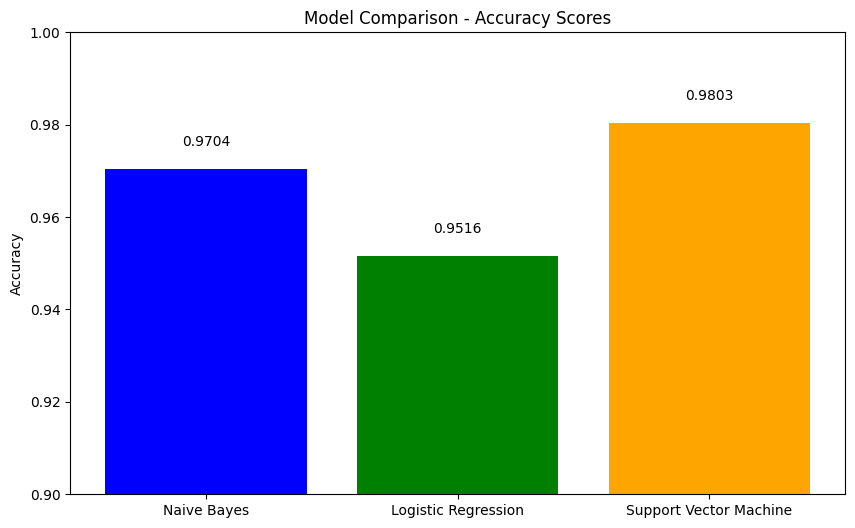


Example Predictions:

Message: Congratulations! You've won a $1000 gift card. Click here to claim your prize!
Prediction: Spam
Confidence: 64.23%

Message: Hi John, just checking in to see if we're still meeting tomorrow at 3pm?
Prediction: Ham
Confidence: 97.65%

Message: URGENT: Your bank account has been compromised. Click this link to secure it now!
Prediction: Ham
Confidence: 68.32%

Message: Your package will be delivered tomorrow at 2pm. Track your order at example.com
Prediction: Ham
Confidence: 90.16%

Message: Free entry in 2 a weekly comp to win FA Cup final tkts 21st May 2005
Prediction: Ham
Confidence: 50.84%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import nltk
import string
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Ensure NLTK resources are downloaded
def download_nltk_resources():
    required_resources = {
        'punkt': 'tokenizers/punkt',
        'stopwords': 'corpora/stopwords',
        'wordnet': 'corpora/wordnet',
        'omw-1.4': 'corpora/omw-1.4' 
    }
    
    print("Checking NLTK resources...")
    for resource, path in required_resources.items():
        try:
            nltk.data.find(path)
            print(f"Found {resource}")
        except LookupError:
            print(f"Downloading {resource}...")
            nltk.download(resource)
            try:
                nltk.data.find(path)
                print(f"Successfully downloaded {resource}")
            except LookupError:
                print(f"Warning: Could not verify {resource} download")

# Download all required NLTK resources
download_nltk_resources()

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load and Prepare the Dataset
def load_dataset():
    try:
        df = pd.read_csv('spam.csv', encoding='latin-1')
        df = df[['v1', 'v2']]  
        df.columns = ['label', 'text']
        return df
    except FileNotFoundError:
        print("\nERROR: Dataset not found!")
        print("Please download the dataset from:")
        print("https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset")
        print("And save it as 'spam.csv' in your working directory")
        exit()

df = load_dataset()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    try:
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Tokenize with fallback to simple split if tokenizer fails
        try:
            tokens = word_tokenize(text)
        except:
            tokens = text.split()
        
        # Remove stopwords
        try:
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words]
        except:
            pass 
        
        # Lemmatization
        try:
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens]
        except:
            pass  
        
        return ' '.join(tokens)
    except Exception as e:
        print(f"Warning: Error processing text - {str(e)}")
        return text  

print("\nPreprocessing text...")
df['processed_text'] = df['text'].apply(preprocess_text)

# Feature Extraction and Model Training
X = df['processed_text']
y = df['label'].map({'ham': 0, 'spam': 1})

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

def train_and_evaluate(model, model_name):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], 
                yticklabels=['Ham', 'Spam'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear')
}

results = {}
for name, model in models.items():
    results[name] = train_and_evaluate(model, name)

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange'])
plt.title('Model Comparison - Accuracy Scores')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.show()

best_model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, 
                             preprocessor=preprocess_text)),
    ('classifier', LogisticRegression(max_iter=1000))
])

best_model.fit(X_train, y_train)

# Example Predictions
test_messages = [
    "Congratulations! You've won a $1000 gift card. Click here to claim your prize!",
    "Hi John, just checking in to see if we're still meeting tomorrow at 3pm?",
    "URGENT: Your bank account has been compromised. Click this link to secure it now!",
    "Your package will be delivered tomorrow at 2pm. Track your order at example.com",
    "Free entry in 2 a weekly comp to win FA Cup final tkts 21st May 2005"
]

predictions = best_model.predict(test_messages)
probabilities = best_model.predict_proba(test_messages)

print("\nExample Predictions:")
for msg, pred, prob in zip(test_messages, predictions, probabilities):
    print(f"\nMessage: {msg}")
    print(f"Prediction: {'Spam' if pred == 1 else 'Ham'}")
    print(f"Confidence: {max(prob):.2%}")